In [1]:
# Base packages
import dill
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from pprint import pprint
from wordcloud import WordCloud
import os,re, nltk, spacy

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Sklearn
from sklearn.externals import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt

# Path
folders = './final/'
file_url = folders + 'lematize_corpus_vec.csv'

model_folders = './models/'
dest_model_file_a = model_folders + 'lda_cvec_uni_a.pkl'
dest_model_file_b = model_folders + 'lda_cvec_uni_b.jlb'
dest_model_file_c = model_folders + 'lda_cvec_uni_c_dill.pkl'

gs_model_bk = './gs_models/cvec_uni.model'
dest_df = './dataframe/cvec_uni.csv'
dest_vec = './vectorizer/cvec_uni.vector'

# Init
nlp = spacy.load("en_core_web_sm",disable=['parser', 'ner'])
GRAMMAGE = (1, 1)
%matplotlib inline

# Custom
%run -i ./python-code/helper.py
%run -i ./python-code/config.py
%run -i ./python-code/nlp_scripts.py

C:\Users\Shaynie\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [11]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

In [2]:
frame = pd.read_csv(file_url, sep='|', encoding="utf-8")
frame.head()

,text,list_text,lemma_text
0,People with an irregular heart beat condition...,"['people', 'with', 'an', 'irregular', 'heart',...",peopl irregular heart beat condit should be cl...
1,Politicians in the Catholic Republic of Irelan...,"['politicians', 'in', 'the', 'catholic', 'repu...",politician cathol republ ireland have overwhel...
2,In the winter months temperatures and humidity...,"['in', 'the', 'winter', 'months', 'temperature...",winter month temperatur humid level plummet as...
3,A system of special measures designed to impro...,"['system', 'of', 'special', 'measures', 'desig...",system special measur design improv fail hospi...
4,A can be hard enough to get on your own Add in...,"['can', 'be', 'hard', 'enough', 'to', 'get', '...",can be hard enough get own add challeng sleep ...


In [3]:
frame = frame[pd.notnull(frame['lemma_text'])]
frame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25729 entries, 0 to 25736
Data columns (total 3 columns):
text          25729 non-null object
list_text     25729 non-null object
lemma_text    25729 non-null object
dtypes: object(3)
memory usage: 804.0+ KB


In [4]:
# Quickly clean the contexts
corpus = frame['lemma_text'].values

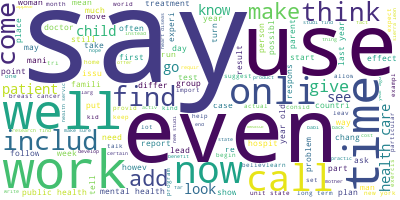

In [6]:
# Join the different processed title together.
long_string = ','.join(corpus)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

In [16]:
# Split corpus into TRAIN, TEST, HOLDON
data_train = corpus[:config.TRAIN_SIZE]
TRAIN_SIZE = config.TRAIN_SIZE +1
TEST_SIZE = config.TEST_SIZE + config.TRAIN_SIZE
data_test = corpus[TRAIN_SIZE:TEST_SIZE]
TEST_SIZE = TEST_SIZE + 1
data_holdon = corpus[TEST_SIZE:]

In [5]:
# Create the Document-Word matrix
vectorizer = CountVectorizer(ngram_range = GRAMMAGE,                  
                             analyzer='word',                  # Bi-grams
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=M_STOP_WORDS,            # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(corpus)

In [6]:
# 8. Check the Sparsicity
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

MemoryError: 

In [7]:
# Build LDA Model
lda_model = LDA(n_topics=E_TOPICS,       # Number of topics
              max_iter=10,               # Max learning iterations
              learning_method='online',   
              random_state=100,          # Random state
              batch_size=128,            # n docs in each learning iter
              evaluate_every = -1,       # compute perplexity every n iters, default: Don't
              n_jobs = -1,               # Use all available CPUs
             )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=6, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [8]:
# 10
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -48322105.674199745
Perplexity:  1868.5071351539746
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 6,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [9]:
## GridSearchCV
# Define Search Param
search_params = {'n_components': N_COMPONENTS, 'learning_decay': LEARNING_DECAY}

# Init the Model
lda = LDA()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params,n_jobs=-1)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\Shaynie\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_components': [6, 10, 15, 20, 25, 30, 50], 'learning_decay': ['.3', '.5', '.7', '.9']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [10]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': '.9', 'n_components': 30}
Best Log Likelihood Score:  -16072990.004219588
Model Perplexity:  1526.989772013541


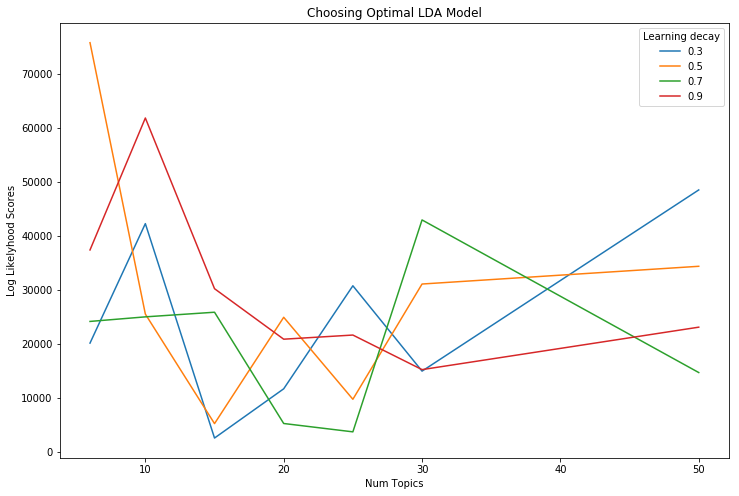

In [12]:
# Get Log Likelyhoods from Grid Search Output
n_topics = search_params['n_components']
learning_decay = LEARNING_DECAY
one_third = len(n_topics)
two_third = one_third*2
three_fourth = one_third*3

gscore = dict(model.cv_results_)
log_likelyhoods_3 = gscore['std_train_score'][0:one_third]
log_likelyhoods_5 = gscore['std_train_score'][one_third:two_third]
log_likelyhoods_7 = gscore['std_train_score'][two_third:three_fourth]
log_likelyhoods_9 = gscore['std_train_score'][three_fourth:]


# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_ if gscore.parameters['learning_decay']==0.9]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_3, label='0.3')
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()


### 1. Saving Model to disk

In [13]:
# Have: best_lda_model


## ----------------------------------------------------------
## ----------------------------------------------------------
## Pickle
## ----------------------------------------------------------
pickle.dump(best_lda_model,open(dest_model_file_a,'wb'))

## Joblib
## ----------------------------------------------------------
joblib.dump(best_lda_model, dest_model_file_b)

## Dill
## ----------------------------------------------------------
dill.dump(best_lda_model, open(dest_model_file_c,'wb'))

## Vectorizer
## ----------------------------------------------------------
dill.dump(vectorizer, open(dest_vec,'wb'))

## ----------------------------------------------------------
## ----------------------------------------------------------
## Backup GridSearchCV models
## ----------------------------------------------------------
dill.dump(model, open(gs_model_bk,'wb'))

## Best topic
## ----------------------------------------------------------
BEST_TOPICS = model.best_params_['n_components']

In [44]:
# best_lda_model = dill.load(open(dest_model_file_c,'rb'))

In [14]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(model.best_params_['n_components'])]

# index names
docnames = ["Doc" + str(i) for i in range(len(corpus))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,dominant_topic
Doc0,0,0,0,0,0.03,0,0,0,0,0.05,0,0,0,0,0.19,0,0.32,0,0.41,0,0,0,0,0,0,0,0,0,0,0,18
Doc1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.74,0.22,0,0,0,0,24
Doc2,0,0,0,0,0,0.16,0,0,0,0.02,0,0.01,0,0,0,0,0,0,0.07,0,0,0,0,0,0,0.39,0,0,0.08,0.26,25
Doc3,0.01,0.91,0,0,0,0,0,0,0,0,0,0,0,0,0.07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Doc4,0.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.06,0,0,0.15,0,0,0,0,0,0.14,0
Doc5,0,0.5,0,0,0,0.03,0,0,0,0,0,0,0.06,0,0.4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Doc6,0,0,0,0,0,0,0.05,0,0,0,0,0,0,0.15,0,0,0,0,0.03,0,0.02,0,0.72,0,0,0,0,0,0,0.03,22
Doc7,0.2,0,0,0,0,0,0,0,0,0,0,0.52,0,0,0,0,0.27,0,0,0,0,0,0,0,0,0,0,0,0,0,11
Doc8,0,0.05,0,0,0,0,0,0,0,0,0,0,0,0,0.06,0,0.25,0,0.62,0,0,0,0,0,0,0,0,0,0.02,0,18
Doc9,0,0,0.09,0,0,0,0.18,0.04,0,0,0,0.34,0,0.03,0,0,0,0,0,0,0,0,0.05,0.06,0,0,0,0.2,0,0,11


In [17]:
df_document_topic.to_csv(dest_df, sep='|')

In [18]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,23,2345
1,16,1535
2,15,1421
3,9,1312
4,12,1283
5,1,1253
6,6,1187
7,26,1171
8,21,1063
9,14,968


In [19]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\Shaynie\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=               x          y  topics  cluster      Freq
topic                                                 
23     -4.545382 -30.491037       1        1  9.063047
16     20.314690  10.668361       2        1  6.049043
14      8.855821 -18.521797       3        1  4.946532
1      -1.079479   5.979483       4        1  4.861046
6       6.318861  -1.135564       5        1  4.451877
12     -2.918878  -3.107945       6        1  4.444707
15      3.181965 -10.458556       7        1  4.127720
22    -11.977144  -5.792320       8        1  4.019758
21      0.871692  15.652660       9        1  3.873811
26      8.816535   8.510040      10        1  3.623510
13     -9.308138  12.813193      11        1  3.619831
2      10.703946  19.892651      12        1  3.600286
29     -5.954447 -12.453720      13        1  3.358701
24    -25.248241 -20.440716      14        1  3.310886
9     -29.826916   4.510312      15        1  3.149364
4      -6.285376  23.757071      16        1  2.967264
3     -16.599094 -29.089109      17        1  2.876452
5      -0.884086 -20.604862      18        1  2.794217
7     -10.666946   3.256127      19        1  2.590512
25      7.851632 -29.134777      20        1  2.564863
0     -11.521993 -20.011917      21        1  2.547877
11    -19.013708  18.829567      22        1  2.349173
17     13.131658  -9.104484      23        1  2.280008
18    -18.350857 -12.603663      24        1  2.120407
27    -19.522078   8.209249      25        1  2.057137
28     24.228983  -6.787981      26        1  1.828845
10     19.527550 -19.093874      27        1  1.828734
19     16.360729   0.763761      28        1  1.741680
20    -29.544914  -8.678412      29        1  1.599613
8     -20.722679  -2.061450      30        1  1.353100, topic_info=      Category          Freq       Term         Total  loglift  logprob
term                                                                   
1940   Default  18160.000000     cancer  18160.000000  30.0000  30.0000
2315   Default  21118.000000      child  21118.000000  29.0000  29.0000
9475   Default  40076.000000    patient  40076.000000  28.0000  28.0000
14366  Default  20213.000000      woman  20213.000000  27.0000  27.0000
3973   Default  17934.000000       drug  17934.000000  26.0000  26.0000
13831  Default   9568.000000     vaccin   9568.000000  25.0000  25.0000
12474  Default  33001.000000      studi  33001.000000  24.0000  24.0000
4977   Default  16744.000000       food  16744.000000  23.0000  23.0000
10858  Default  31972.000000   research  31972.000000  22.0000  22.0000
5895   Default  53979.000000     health  53979.000000  21.0000  21.0000
6149   Default  22951.000000     hospit  22951.000000  20.0000  20.0000
14007  Default  10135.000000      virus  10135.000000  19.0000  19.0000
2010   Default  28846.000000       care  28846.000000  18.0000  18.0000
8725   Default  10865.000000        nhs  10865.000000  17.0000  17.0000
9404   Default   8158.000000     parent   8158.000000  16.0000  16.0000
5906   Default  10411.000000      heart  10411.000000  15.0000  15.0000
1049   Default   6450.000000       babi   6450.000000  14.0000  14.0000
1627   Default   9583.000000      brain   9583.000000  13.0000  13.0000
6491   Default  10966.000000     infect  10966.000000  12.0000  12.0000
14202  Default   9200.000000     weight   9200.000000  11.0000  11.0000
6601   Default   6611.000000      insur   6611.000000  10.0000  10.0000
11867  Default   6229.000000      sleep   6229.000000   9.0000   9.0000
7757   Default   9876.000000        man   9876.000000   8.0000   8.0000
4077   Default  12095.000000        eat  12095.000000   7.0000   7.0000
3732   Default  20132.000000     diseas  20132.000000   6.0000   6.0000
4525   Default   7507.000000    exercis   7507.000000   5.0000   5.0000
1911   Default   8270.000000     calori   8270.000000   4.0000   4.0000
11389  Default   9686.000000     school   9686.000000   3.0000   3.0000
4682   Default   8523.000000        f

In [22]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aafter,aall,aalmost,aan,aand,aani,aanyth,aap,aar,...,zoloft,zombi,zone,zoo,zoom,zoonot,zucchini,zucker,zuckerman,zumba
Topic0,0.04,0.04,0.040000,0.04,0.760166,6.967427,0.04,0.04,0.040000,0.04,...,0.04,0.04,5.704535,0.04,0.04,0.040000,0.04,0.040000,0.04,0.04000
Topic1,0.04,0.04,0.040000,0.04,0.040000,0.040000,0.04,0.04,0.040000,0.04,...,0.04,0.04,0.040000,0.04,0.04,0.040000,362.04,0.040000,0.04,0.04000
Topic2,0.04,0.04,0.040000,0.04,0.040000,0.040000,0.04,0.04,0.040000,0.04,...,0.04,0.04,5.702467,0.04,0.04,0.040000,0.04,0.040000,0.04,0.04000
Topic3,0.04,0.04,2.667124,0.04,0.040000,0.040000,0.04,0.04,2.335642,0.04,...,0.04,0.04,72.297046,0.04,0.04,0.040000,0.04,5.273642,0.04,37.18287
Topic4,0.04,0.04,0.040000,0.04,0.040000,0.040000,0.04,0.04,0.040000,0.04,...,0.04,0.04,0.040003,0.04,0.04,11.063112,0.04,0.040000,0.04,0.04000


In [23]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,food,eat,sugar,calori,school,health,consum,make,nutrit,healthi,drink,obes,new,child,add
Topic 1,fat,calori,make,protein,oil,healthi,gram,pepper,serv,add,fiber,recip,fresh,low,chees
Topic 2,health,nhs,govern,servic,minist,labour,wale,make,care,patient,peopl,year,parti,polit,elect
Topic 3,sleep,time,feel,stress,day,make,hour,school,kid,good,run,just,night,activ,help
Topic 4,health,case,virus,hospit,offici,infect,peopl,diseas,patient,cdc,state,public,contact,report,symptom
Topic 5,patient,hospit,care,doctor,nurs,medic,health,emerg,staff,servic,need,time,depart,home,clinic
Topic 6,food,product,water,skin,hair,caus,fish,contain,make,supplement,vitamin,consum,eat,oil,includ
Topic 7,health,year,peopl,countri,citi,air,child,polio,tooth,program,communiti,area,home,new,public
Topic 8,child,studi,research,age,parent,babi,year,percent,risk,health,high,old,like,young,woman
Topic 9,health,peopl,mental,care,patient,need,servic,make,support,ill,help,public,experi,nurs,good


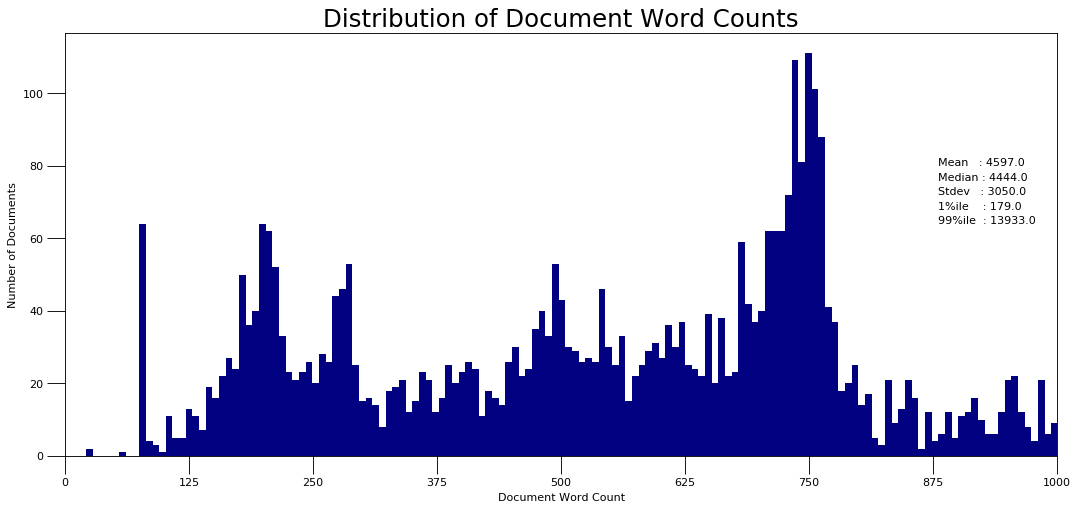

In [25]:
doc_lens = [len(d) for d in frame['list_text'].values]

# Plot
plt.figure(figsize=(16,7), dpi=80)
plt.hist(doc_lens, bins = 10000, color='navy')
plt.text(880, 80, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(880, 76, "Median : " + str(round(np.median(doc_lens))))
plt.text(880, 72, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(880, 68, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(880, 64, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [27]:
unseem_data = '''
Ultra-processed foods - such as chicken nuggets, ice cream and breakfast cereals - have been linked to early death and poor health, scientists say. 
Researchers in France and Spain say the amount of such food being eaten has soared.
Their studies are not definite proof of harm but do come hot on the heels of trials suggesting ultra-processed foods 
.
Experts expressed caution but called for further investigation. 
The term comes from a way of classifying food by how much industrial processing it has been through.
The lowest category is "unprocessed or minimally processed foods", which include: • fruit • vegetables • milk • meat • legumes such as lentils • seeds • grains such as rice • eggs
"Processed foods" have been altered to make them last longer or taste better - generally using salt, oil, sugar or fermentation.
This category includes: • cheese • bacon • home-made bread • tinned fruit and vegetables • smoked fish • beer
Then come "ultra-processed foods", which have been through more substantial industrial processing and often have long ingredient lists on the packet, including added preservatives, sweeteners or colour enhancers. 
If a product contains more than five ingredients, it is probably ultra-processed, says Prof Maira Bes-Rastrollo, of the University of Navarra, citing a maxim.
Examples include: • processed meat such as sausages and hamburgers • breakfast cereals or cereal bars • instant soups • sugary fizzy drinks • chicken nuggets • cake • chocolate • ice cream • mass-produced bread • many "ready to heat" meals such as pies and pizza | meal-replacement shakes 
, by the University of Navarra, in Spain, followed 19,899 people for a decade and assessed their diet every other year. There were 335 deaths during the study.
But for every 10 deaths among those eating the least ultra-processed food, there were 16 deaths among those eating the most (more than four portions a day).
, by the University of Paris, followed 105,159 people for five years and assessed their diet twice a year.
It showed those eating more ultra-processed food had worse heart health. 
Rates of cardiovascular disease were 277 per 100,000 people per year among those eating the most ultra-processed food, compared with 242 per 100,000 among those eating the least. 
The rapid increase of ultra-processed foods over less processed foods, "may drive a substantial burden of cardiovascular diseases in the next decades," said Dr Mathilde Touvier, of the University of Paris.
"[The] evidence is accumulating," said Dr Touvier, noting "increasing numbers of independent studies". Prof Bes-Rastrollo said she was "very certain" ultra-processed foods were bad for health.
Last year, a link was made with 
.
The challenge is being 100% sure. The studies have spotted a pattern between highly processed food and poor health but they cannot prove that one causes the other. 
Those who ate the most ultra-processed food were also more likely to have other unhealthy behaviours, such as smoking, which the researchers tried to account for. 
But there's no guarantee everything relevant was covered, says Kevin McConway, a professor of statistics at The Open University.
"These studies do increase my confidence that there's something real behind these associations - but I'm still far from sure."
The first trial of ultra-processed foods showed they led people to eat more and put on weight. 
Researchers at the US National Institutes of Health monitored every morsel of food that volunteers ate for a month.
And when given ultra-processed food, they ate 500 calories a day more than when they were given unprocessed meals.
Other suggestions include: 
These ideas still need researching.
While the term ultra-processed food may be new, the health advice will be very familiar: adopt a Mediterranean-style diet.
Such a diet includes plenty of minimally or unprocessed foods, such as fruit, vegetables, fish, nuts and seeds, beans, lentils and wholegrains, said Victoria Taylor, senior dietician at the British Heart Foundation.
"This, along with exercising regularly and not smoking, has been shown to be beneficial for lowering risk of heart and circulatory disease."
Measures such as taxation and marketing restrictions on ultra-processed foods, should be considered, said Prof Bes-Rastrollo, given the weight of evidence. 
There are certainly a lot of critics. 
The labelling of food as ultra-processed could be inconsistent, said Dr Gunter Kuhnle, an expert in nutrition and health at the University of Reading
"It is also not obvious why salami is considered to be ultra-processed, yet cheese, which often requires considerably more processing steps and additives, is not.  The classification combines a wide range of foods with very different potential impacts on health, which limits its usefulness as a basis for recommendations."
The studies were published in the British Medical Journal.
'''

In [30]:
# Define function to predict topic for a given text document.

# Predict the topic
# for text in data_test:
#     topic, prob_scores = predict_topic(text = text)
#     print(topic)
topic, prob_scores = predict_topic(unseem_data)
print(topic)
pprint(prob_scores)

[[4.50995266e-01 8.39827718e-02 1.02301790e-04 1.02301790e-04
  1.02301790e-04 1.02301790e-04 4.34856794e-02 1.02301790e-04
  1.02301790e-04 1.02301790e-04 2.09841803e-01 2.51202085e-02
  1.43807250e-01 1.02301790e-04 1.02301790e-04 1.02301790e-04
  1.02301790e-04 1.02301790e-04 1.02301790e-04 1.02301790e-04
  1.02301790e-04 3.15594166e-02 9.46847439e-03 1.02301790e-04
  1.02301790e-04]] 0
['food', 'eat', 'sugar', 'calori', 'school', 'health', 'consum', 'make', 'nutrit', 'healthi', 'drink', 'obes', 'new', 'child', 'add']
array([[4.50995266e-01, 8.39827718e-02, 1.02301790e-04, 1.02301790e-04,
        1.02301790e-04, 1.02301790e-04, 4.34856794e-02, 1.02301790e-04,
        1.02301790e-04, 1.02301790e-04, 2.09841803e-01, 2.51202085e-02,
        1.43807250e-01, 1.02301790e-04, 1.02301790e-04, 1.02301790e-04,
        1.02301790e-04, 1.02301790e-04, 1.02301790e-04, 1.02301790e-04,
        1.02301790e-04, 3.15594166e-02, 9.46847439e-03, 1.02301790e-04,
        1.02301790e-04]])


### Fitting with KMeans

Component's weights: 
 [[ 0.09  0.07  0.06  0.15  0.09  0.25  0.08  0.1   0.27  0.15  0.13  0.16
   0.09  0.07  0.1   0.12  0.05  0.62  0.45  0.11  0.16  0.07  0.12  0.19
   0.14]
 [-0.02 -0.06  0.01 -0.1  -0.02 -0.02 -0.04 -0.02 -0.11 -0.05 -0.09 -0.07
  -0.02 -0.03 -0.02 -0.06 -0.02 -0.44  0.86 -0.04 -0.07 -0.05 -0.06  0.05
   0.02]]
Perc of Variance Explained: 
 [0.03 0.1 ]


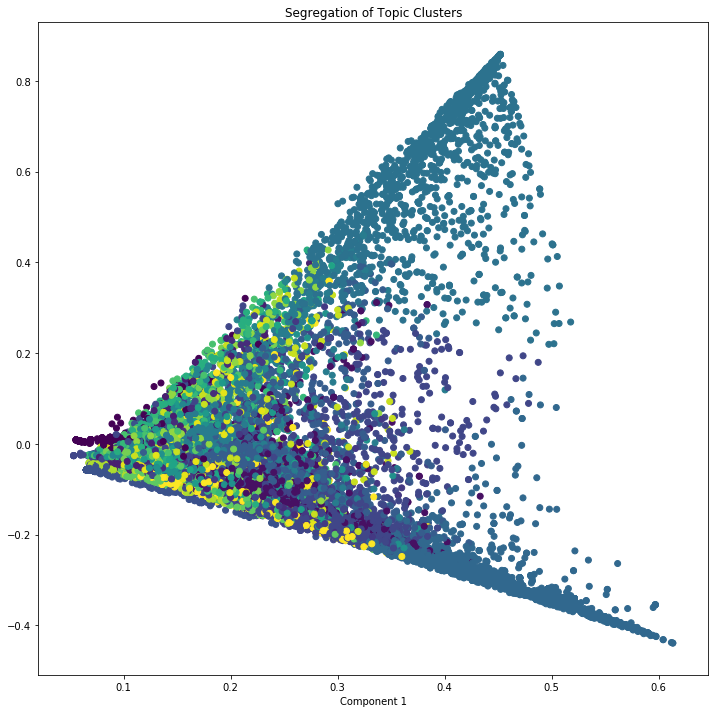

In [31]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=BEST_TOPICS, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plotting clusters
plotting_clusters(x, y, clusters)

In [32]:
from sklearn.metrics.pairwise import euclidean_distances

def similar_documents(text, doc_topic_probs, documents = corpus, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)

In [33]:
# Get similar documents
doc_ids, docs = similar_documents(text=unseem_data, doc_topic_probs=lda_output, documents = corpus, top_n=1, verbose=True)
print('\n', docs[0][:500])

[[4.50995266e-01 8.39827718e-02 1.02301790e-04 1.02301790e-04
  1.02301790e-04 1.02301790e-04 4.34856794e-02 1.02301790e-04
  1.02301790e-04 1.02301790e-04 2.09841803e-01 2.51202085e-02
  1.43807250e-01 1.02301790e-04 1.02301790e-04 1.02301790e-04
  1.02301790e-04 1.02301790e-04 1.02301790e-04 1.02301790e-04
  1.02301790e-04 3.15594166e-02 9.46847439e-03 1.02301790e-04
  1.02301790e-04]] 0
Topic KeyWords:  ['food', 'eat', 'sugar', 'calori', 'school', 'health', 'consum', 'make', 'nutrit', 'healthi', 'drink', 'obes', 'new', 'child', 'add']
Topic Prob Scores of text:  [[0.5 0.1 0.  0.  0.  0.  0.  0.  0.  0.  0.2 0.  0.1 0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]]
Most Similar Doc's Probs:   [[0.4 0.  0.  0.  0.  0.  0.  0.1 0.  0.  0.3 0.  0.1 0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0. ]]

 everyon know fast food be not healthi be link weight gain obes epidem after all most fast food be laden fat sugar salt process carb stuff doctor can tell cut back new studi irish research 

### Fitting with DBSCAN

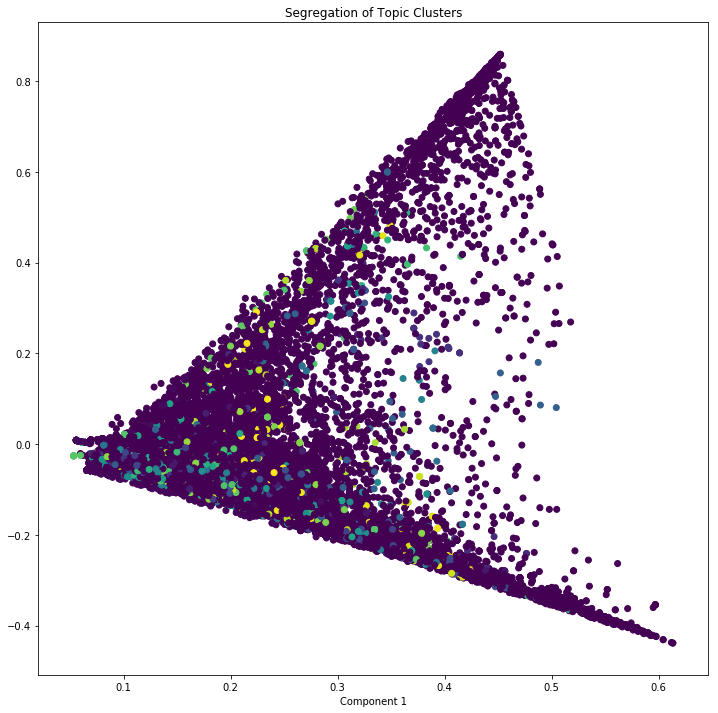

In [34]:
# Construct the DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# X = ss.fit_transform(lda_output)

dbscan_clusters = DBSCAN(eps=0.123, min_samples = 4).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Plotting clusters
plotting_clusters(x, y, dbscan_clusters)